In [63]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
alt.data_transformers.disable_max_rows()
alt.display.renderers.enable('svg')
import matplotlib.pyplot as plt

import act
import act.discovery, act.io

import metpy.calc, metpy.constants
from metpy.units import units
import glob
from tqdm import tqdm
from sublimpy import utils
import datetime as dt
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

In [64]:
# for SAIL data queries
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
start_date = "20230409"
end_date = "20230419"
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/"

# Observations

## SOS towers

In [65]:
sos_df = pd.read_parquet("../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet")
sos_df_localtime = utils.modify_df_timezone(
    sos_df,
    'UTC',
    'US/Mountain'
)


## SAIL Gothic QC'd Radiation Data

In [73]:
# files = act.discovery.download_arm_data(
#     username, token,
#     'gucqcrad1longM1.c2',
#     '20230101',
#     '20230201',
#     output=os.path.join(data_dir, 'gucqcrad1longM1.c2')
# )

files = glob.glob(os.path.join(data_dir, 'gucqcrad1longM1.c2', "*.cdf"))

In [75]:
### PREP SAIL DATA
sail_rad_ds = xr.open_mfdataset(files)
vars =  pd.Series(sail_rad_ds.data_vars).astype(str)

sail_rad_ds['Rnet'] = (
    sail_rad_ds['down_long_hemisp']
    + sail_rad_ds['BestEstimate_down_short_hemisp']
    - sail_rad_ds['up_long_hemisp']
    - sail_rad_ds['up_short_hemisp']
)

### PREP SOS DATA
sos_src = sos_df[sos_df.variable.isin(['Rsw_in_9m_d', 'Rsw_out_9m_d', 'Rlw_in_9m_d', 'Rlw_out_9m_d', 'Rnet_9m_d'])]
sos_src = sos_src[sos_src.time > '20230101']
sos_src = sos_src[sos_src.time < '20230401']
sos_src = sos_src.set_index('time')

# Plot time series

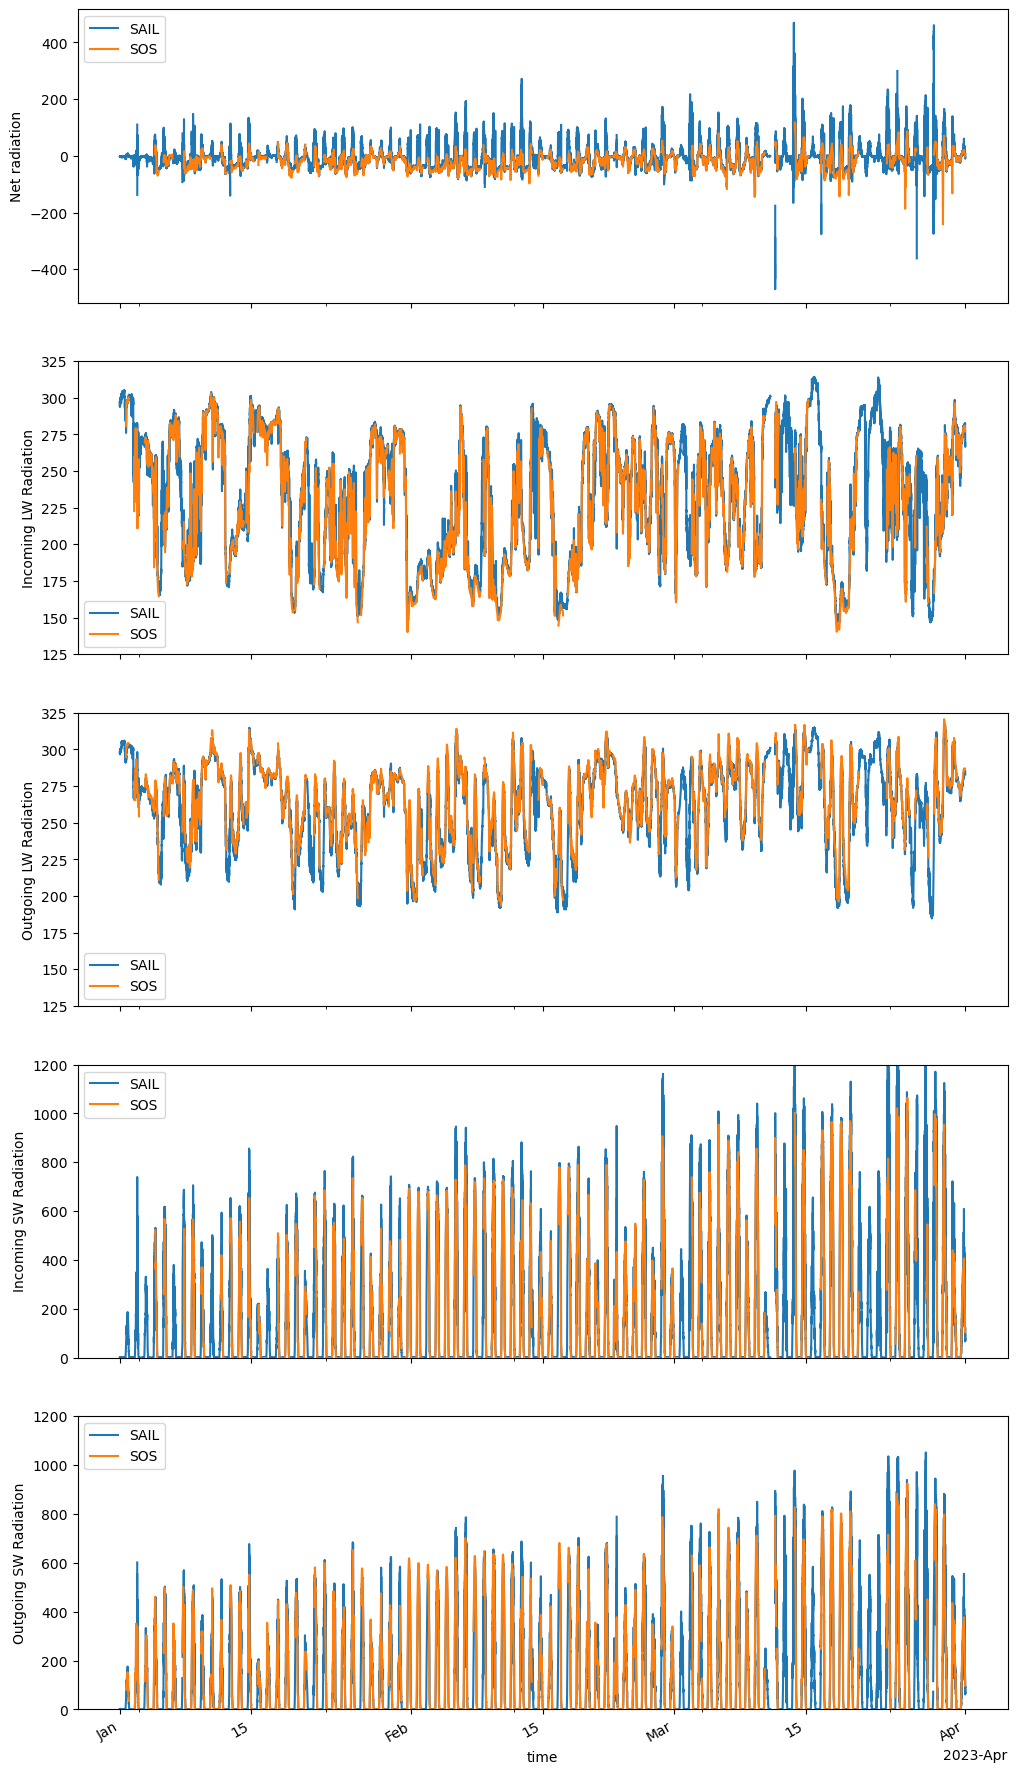

In [76]:
fig, axes = plt.subplots(5,1, figsize=(12,25), sharex=True)

### NET RADIATION
sail_rad_ds['Rnet'].plot(ax=axes[0], label='SAIL', zorder=1)
sos_src.query("variable == 'Rnet_9m_d'").value.plot(ax=axes[0], label='SOS', zorder=2)
axes[0].set_ylabel('Net radiation')
axes[0].legend()

### LONGWAVE RADIATION
sail_rad_ds['down_long_hemisp'].plot(ax=axes[1], label = 'SAIL', zorder=1)
sos_src.query("variable == 'Rlw_in_9m_d'").value.plot(ax=axes[1], label = 'SOS', zorder=2)
axes[1].set_ylabel('Incoming LW Radiation')
axes[1].legend()
axes[1].set_ylim(125, 325)

sail_rad_ds['up_long_hemisp'].plot(ax=axes[2], label = 'SAIL', zorder=1)
sos_src.query("variable == 'Rlw_out_9m_d'").value.plot(ax=axes[2], label = 'SOS', zorder=2)
axes[2].set_ylabel('Outgoing LW Radiation')
axes[2].legend()
axes[2].set_ylim(125, 325)

### SHORTWAVE RADIATION
sail_rad_ds['BestEstimate_down_short_hemisp'].plot(ax=axes[3], label = 'SAIL', zorder=1)
sos_src.query("variable == 'Rsw_in_9m_d'").value.plot(ax=axes[3], label = 'SOS', zorder=2)
axes[3].set_ylabel('Incoming SW Radiation')
axes[3].legend()
axes[3].set_ylim(0, 1200)

sail_rad_ds['up_short_hemisp'].plot(ax=axes[4], label = 'SAIL', zorder=1)
sos_src.query("variable == 'Rsw_out_9m_d'").value.plot(ax=axes[4], label = 'SOS', zorder=2)
axes[4].set_ylabel('Outgoing SW Radiation')
axes[4].legend()
axes[4].set_ylim(0, 1200)


plt.show()

## Plot Scatterplots

In [77]:
sail_rad_df_30min  = sail_rad_ds[[
    'down_long_hemisp',
    'up_long_hemisp',
    'BestEstimate_down_short_hemisp',
    'up_short_hemisp',
]].to_dataframe().resample('30min').mean()

In [78]:
compare_df = sos_src[sos_src.variable.isin([
    'Rlw_in_9m_d',
    'Rlw_out_9m_d',
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',
])].pivot_table(index='time', values='value', columns='variable').join(sail_rad_df_30min)

In [84]:
def compare_func(kps_col, sail_col, kps_col_title, sail_col_title, domain=[0,1100]):
    cols = [
        kps_col,
        sail_col,
    ]
    slope, intercept = np.polyfit(
        compare_df[cols].dropna()[kps_col], 
        compare_df[cols].dropna()[sail_col], 
        1
    )
    # PLOT LINE OF BEST FIT
    best_fit_df = pd.DataFrame({
        'x': domain,
        'y': [slope * x + intercept for x in domain]
    })
    # Create the best-fit line chart
    best_fit_line = alt.Chart(best_fit_df).mark_line(color='red').encode(
        alt.X('x', title='').scale(domain=domain, nice=False),
        alt.Y('y', title='').scale(domain=domain, nice=False)
    )
    # PLOT 1 to 1 line
    one_to_one_df = pd.DataFrame({'x': domain,'y': domain})
    one_to_one_line = alt.Chart(one_to_one_df).mark_line(
        color='black', strokeDash=[5, 5]
    ).encode(
        alt.X('x', title='').scale(domain=domain, nice=False),
        alt.Y('y', title='').scale(domain=domain, nice=False)
    )
    r2 = r2_score(
        compare_df[cols].dropna()[kps_col],
        compare_df[cols].dropna()[sail_col],
    )
    rmse = root_mean_squared_error(
        compare_df[cols].dropna()[kps_col],
        compare_df[cols].dropna()[sail_col],
    )
    return best_fit_line + one_to_one_line + alt.Chart(compare_df).mark_circle(size=5).encode(
        alt.X(kps_col).title(kps_col_title).scale(domain=domain, nice=False),
        alt.Y(sail_col).title(sail_col_title).scale(domain=domain, nice=False),
    ).properties(title=f"""
        Slope: {round(slope,5)}, r2: {round(r2,3)}, RMSE: {int(round(rmse, 0))}
    """)
plot_sw_d = compare_func(
    'Rsw_in_9m_d', 
    'BestEstimate_down_short_hemisp', 
    'Kettle Ponds SOS SW_D (W/m^2)',
    'Gothic SAIL SW_D (W/m^2)'
) 
plot_lw_d = compare_func(
    'Rlw_in_9m_d', 
    'down_long_hemisp', 
    'Kettle Ponds SOS LW_D (W/m^2)',
    'Gothic SAIL LW_D (W/m^2)',
    domain=[125,325]
)
plot_sw_u = compare_func(
    'Rsw_out_9m_d', 
    'up_short_hemisp', 
    'Kettle Ponds SOS SW_U (W/m^2)',
    'Gothic SAIL SW_U (W/m^2)',
) 
plot_lw_u = compare_func(
    'Rlw_out_9m_d', 
    'up_long_hemisp', 
    'Kettle Ponds SOS LW_U (W/m^2)',
    'Gothic SAIL LW_U (W/m^2)',
    domain=[125,325]
)
chart = (
    (plot_sw_d | plot_lw_d)
    &
    (plot_sw_u | plot_lw_u)
)

In [86]:
chart.save('sail_sos_comparison.png', scale_factor=5)

In [87]:
chart